In [1]:
import pandas as pd
import numpy as np
from algorithms import EllipsoidPricingSBB, EllipsoidPricingWBB, EllipsoidPricingSBBCuts, EllipsoidPricingWBBCuts
import matplotlib.pyplot as plt
from tqdm import tqdm
from typing import List, Dict, Tuple

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
columns = []
for i in range(1, 11):
    columns.append('ask_price_' + str(i))
    columns.append('ask_size_' + str(i))
    columns.append('bid_price_' + str(i))
    columns.append('bid_size_' + str(i))

In [3]:
df = pd.read_csv('MSFT_2012-06-21_34200000_57600000_orderbook_10.csv',
                 header=None, names=columns)

In [4]:
print(df.shape)
df.head()

(668765, 40)


,ask_price_1,ask_size_1,bid_price_1,bid_size_1,ask_price_2,ask_size_2,bid_price_2,bid_size_2,ask_price_3,ask_size_3,...,bid_price_8,bid_size_8,ask_price_9,ask_size_9,bid_price_9,bid_size_9,ask_price_10,ask_size_10,bid_price_10,bid_size_10
0,309900,3788,309500,300,310500,100,309300,3986,310600,100,...,308600,400,311300,100,308500,400,311400,100,308400,1600
1,309900,3788,309500,300,310500,200,309300,3986,310600,100,...,308600,400,311300,100,308500,400,311400,100,308400,1600
2,309900,3788,309500,300,310400,100,309300,3986,310500,200,...,308600,400,311100,4500,308500,400,311300,100,308400,1600
3,309900,3788,309500,300,310400,100,309300,3986,310500,300,...,308600,400,311100,4500,308500,400,311300,100,308400,1600
4,309900,3788,309500,300,310400,100,309300,3986,310500,300,...,308600,400,311100,4500,308500,400,311300,100,308400,1600


In [5]:
#Calculate the spread
df['spread'] = df['ask_price_1'] - df['bid_price_1']

In [6]:
#Find the max in the size columns
df.filter(like='size').max().sort_values(ascending=False).head()

ask_size_2    219123
ask_size_1    216430
bid_size_5    167571
bid_size_6    151271
bid_size_1    128500
dtype: int64

In [7]:
# Log transform the size columns
df.loc[:, df.columns.str.contains('size')] = np.log(df.loc[:, df.columns.str.contains('size')])

# Normalize the size columns by the max-min range
max_size = df.filter(like='size').max().max()
min_size = df.filter(like='size').min().min()
df.loc[:, df.columns.str.contains('size')] = (df.loc[:, df.columns.str.contains('size')] - min_size) / (max_size - min_size)

# Normalize the price columns by the max-min range
max_price = df.filter(like='price').max().max()
min_price = df.filter(like='price').min().min()
df.loc[:, df.columns.str.contains('price')] = (df.loc[:, df.columns.str.contains('price')] - min_price) / (max_price - min_price)

# Normalize the spread
df.loc[:, 'spread'] = (df.loc[:, 'spread'] - df.spread.min()) / (df.spread.max() - df.spread.min())

In [8]:
# Calculate the maz norm of each row
max_norm = np.linalg.norm(df, axis=1).max()
print(max_norm)

# Normalize the entire dataframe
df = df / max_norm

5.112088883024016


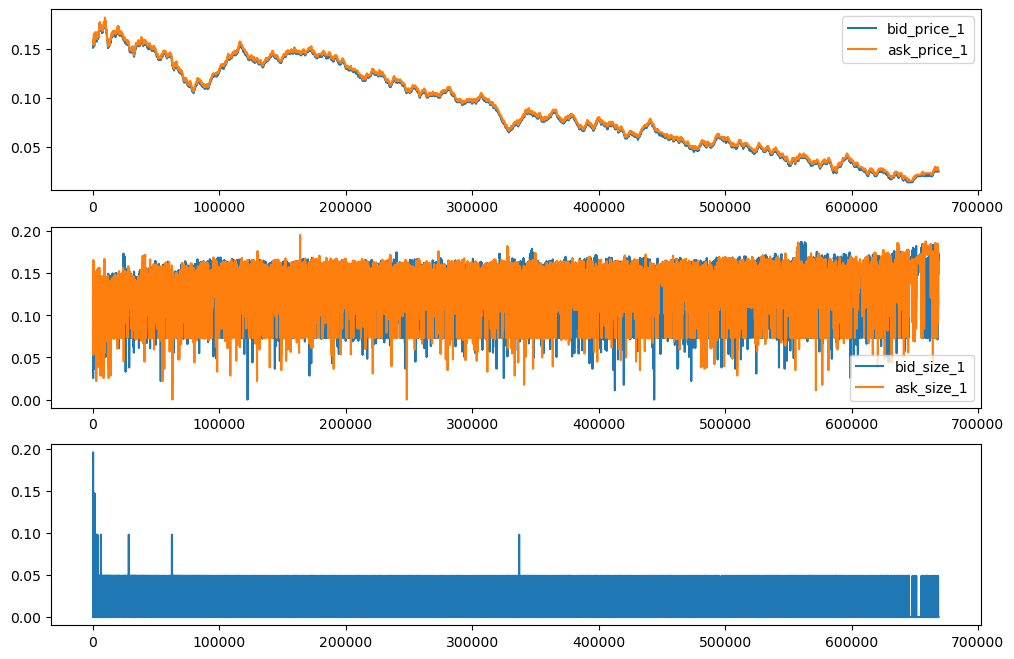

In [9]:
# Plot bid1 and ask1 prices and sizes in two subplots
fig, ax = plt.subplots(3, 1, figsize=(12, 8))
df[['bid_price_1', 'ask_price_1']].plot(ax=ax[0])
df[['bid_size_1', 'ask_size_1']].plot(ax=ax[1])
df['spread'].plot(ax=ax[2])
plt.show()

In [10]:
# The book is very liquid. 
# We can implement the base version of the feature-based bilateral trade paper.

In [6]:
# Sample two random vectors of parameters that are inside a ball of radius 1
np.random.seed(11)
DIMENSIONS = 41
theta_unnorm_s = np.random.uniform(size=DIMENSIONS)
theta_s = theta_unnorm_s / np.sqrt(DIMENSIONS)

theta_unnorm_b = np.random.uniform(size=DIMENSIONS)
theta_b = theta_unnorm_b / np.sqrt(DIMENSIONS)

print(f"Norm of theta_s: {np.linalg.norm(theta_s)}")
print(f"Norm of theta_b: {np.linalg.norm(theta_b)}")

Norm of theta_s: 0.5633624088012478
Norm of theta_b: 0.5859418892842306


## Linear hidden valuations

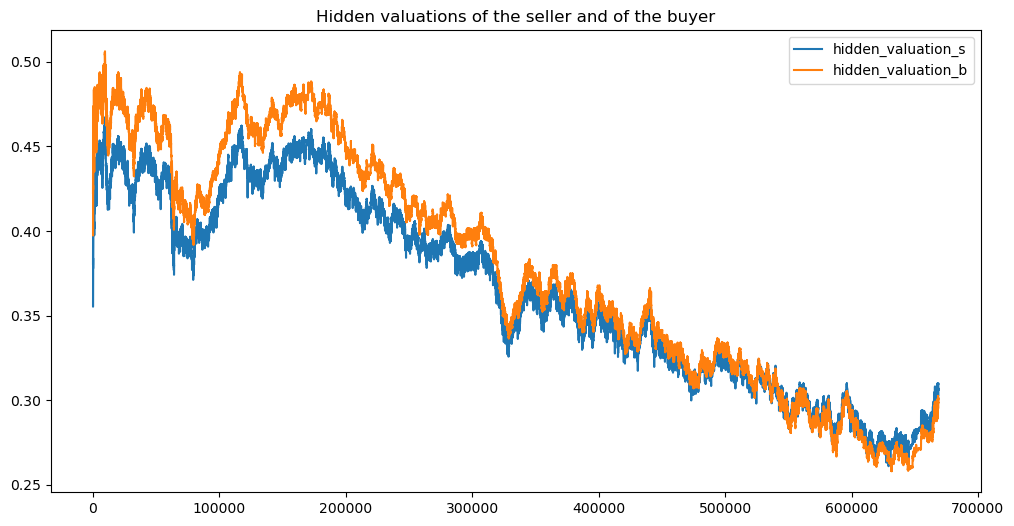

In [11]:
# Calculate the hidden valuations
df['hidden_valuation_s'] = np.dot(df.iloc[:, :DIMENSIONS], theta_s)
df['hidden_valuation_b'] = np.dot(df.iloc[:, :DIMENSIONS], theta_b)

# Plot the hidden valuations on top of each other
df[['hidden_valuation_s', 'hidden_valuation_b']].plot(figsize=(12, 6))
plt.title('Hidden valuations of the seller and of the buyer')
plt.show()

In [19]:
df['s_floor_SBB'] = None
df['s_ceil_SBB'] = None
df['b_floor_SBB'] = None
df['b_ceil_SBB'] = None
df['p_SBB'] = None

T = df.shape[0]
EPSILON = 1*1*DIMENSIONS**2/T
brokerSBB = EllipsoidPricingSBB(epsilon=EPSILON, d=DIMENSIONS)

for i in tqdm(range(T)):
    x = df.iloc[i, :DIMENSIONS].values
    s = df.iloc[i, 41] # hidden_valuation_s
    b = df.iloc[i, 42] # hidden_valuation_b
    p, q = brokerSBB.get_price(x)
    feedback_s = s <= p
    feedback_b = b >= q
    brokerSBB.update_ellipsoids(feedback_s, feedback_b)
    # The budget will always be 0

    # Save the valuation bounds and the price
    df.loc[i, 's_floor_SBB'] = brokerSBB.s_floor
    df.loc[i, 's_ceil_SBB'] = brokerSBB.s_ceil
    df.loc[i, 'b_floor_SBB'] = brokerSBB.b_floor
    df.loc[i, 'b_ceil_SBB'] = brokerSBB.b_ceil
    df.loc[i, 'p_SBB'] = p

100%|██████████| 668765/668765 [05:42<00:00, 1953.09it/s]


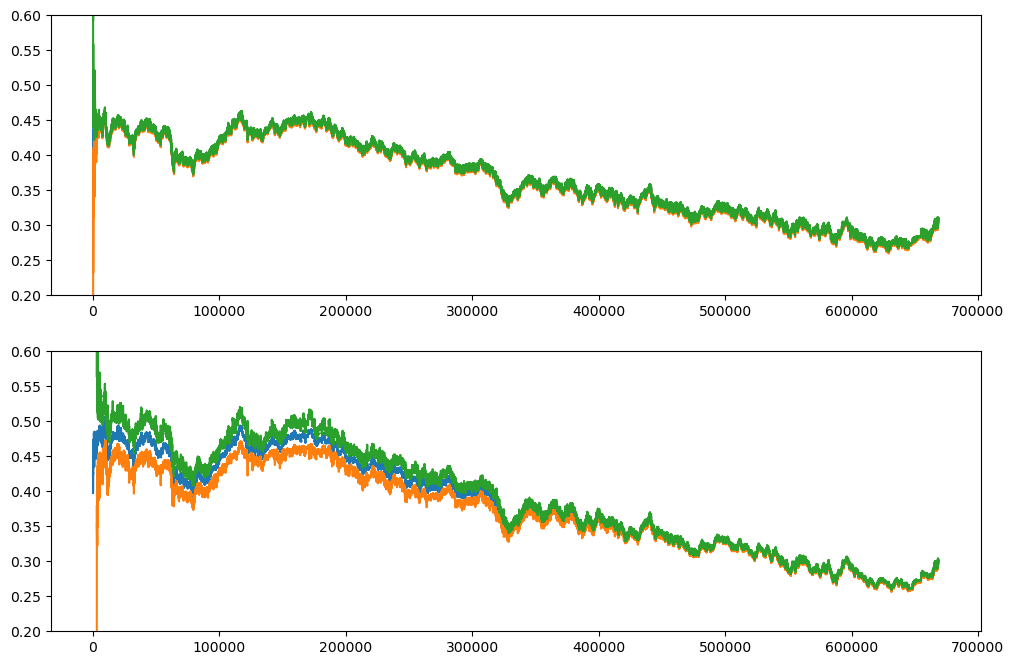

In [14]:
# Plot floors and ceilings against hidden valuations
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
ax[0].plot(df[['hidden_valuation_s', 's_floor_SBB', 's_ceil_SBB']])
ax[1].plot(df[['hidden_valuation_b', 'b_floor_SBB', 'b_ceil_SBB']])
ax[0].set_ylim(0.2, 0.6)
ax[1].set_ylim(0.2, 0.6)
plt.show()

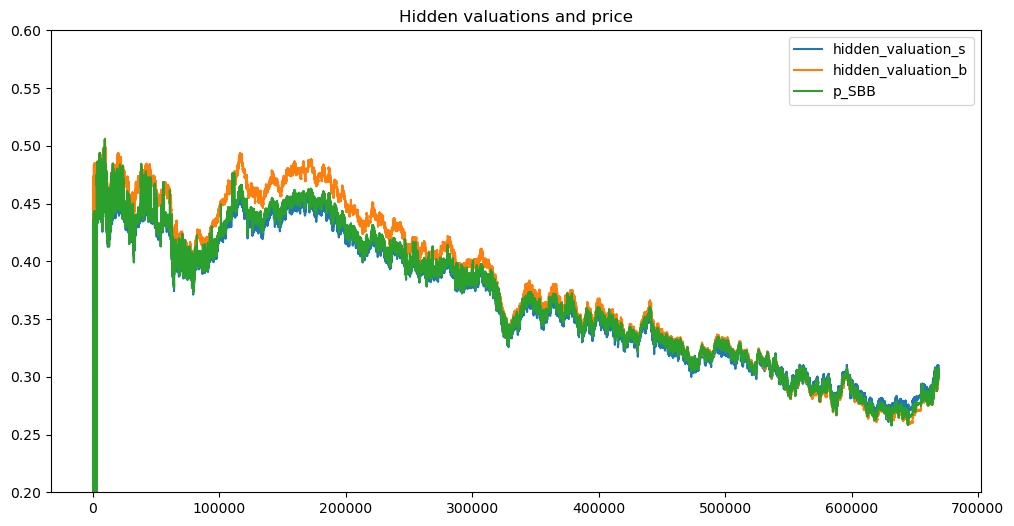

In [15]:
# Plot price against hidden valuations
df[['hidden_valuation_s', 'hidden_valuation_b', 'p_SBB']].plot(figsize=(12, 6))
plt.title('Hidden valuations and price')
plt.ylim(0.2, 0.6)
plt.show()

Percentage of accepted trades: 0.7491570282535719
Cumulative Gain From Trade: 8426.809073368533
Optimal Gain From Trade: 8558.153490124405


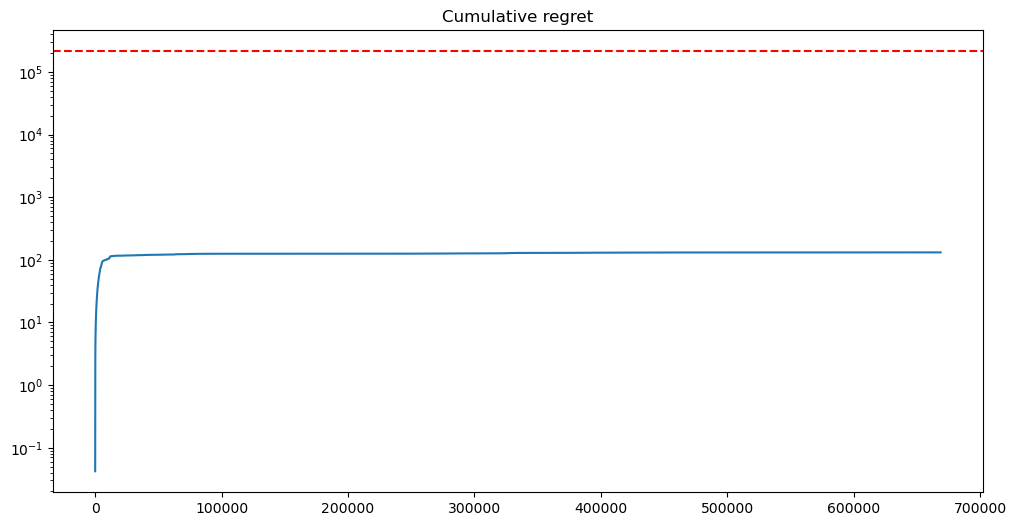

In [34]:
# Percentage of accepted trades
accepted = (df['p_SBB'] >= df['hidden_valuation_s']) & (df['p_SBB'] <= df['hidden_valuation_b'])
gft = accepted * (df['hidden_valuation_b'] - df['hidden_valuation_s'])
optimal_gft = (df['hidden_valuation_b'] - df['hidden_valuation_s']).clip(0)
regret = optimal_gft - gft
print(f"Percentage of accepted trades: {accepted.mean()}")
print(f"Cumulative Gain From Trade: {gft.sum()}")
print(f"Optimal Gain From Trade: {optimal_gft.sum()}")

# Theoretical worst-case regret
theoretical_regret = 10 * DIMENSIONS ** 2 * np.log(20*(DIMENSIONS+1)*T/DIMENSIONS**2)

# Plot the cumulative regret
regret.cumsum().plot(figsize=(12, 6))
plt.axhline(theoretical_regret, color='red', linestyle='--')
plt.title('Cumulative regret')
plt.yscale('log')
plt.show()

In [35]:
df['s_floor_WBB'] = None
df['s_ceil_WBB'] = None
df['b_floor_WBB'] = None
df['b_ceil_WBB'] = None
df['p_WBB'] = None
df['q_WBB'] = None

T = df.shape[0]
EPSILON = 1*1*DIMENSIONS**2/T
brokerWBB = EllipsoidPricingWBB(epsilon=EPSILON, d=DIMENSIONS)

for i in tqdm(range(T)):
    x = df.iloc[i, :DIMENSIONS].values
    s = df.iloc[i, 41] # hidden_valuation_s
    b = df.iloc[i, 42] # hidden_valuation_b
    p, q = brokerWBB.get_price(x)
    feedback_s = s <= p
    feedback_b = b >= q
    brokerWBB.update_ellipsoids(feedback_s, feedback_b)
    if feedback_s and feedback_b:
        brokerWBB.update_budget(q-p)

    # Save the valuation bounds and the price
    df.loc[i, 's_floor_WBB'] = brokerWBB.s_floor
    df.loc[i, 's_ceil_WBB'] = brokerWBB.s_ceil
    df.loc[i, 'b_floor_WBB'] = brokerWBB.b_floor
    df.loc[i, 'b_ceil_WBB'] = brokerWBB.b_ceil
    df.loc[i, 'p_WBB'] = p
    df.loc[i, 'q_WBB'] = q

100%|██████████| 668765/668765 [06:08<00:00, 1813.49it/s]


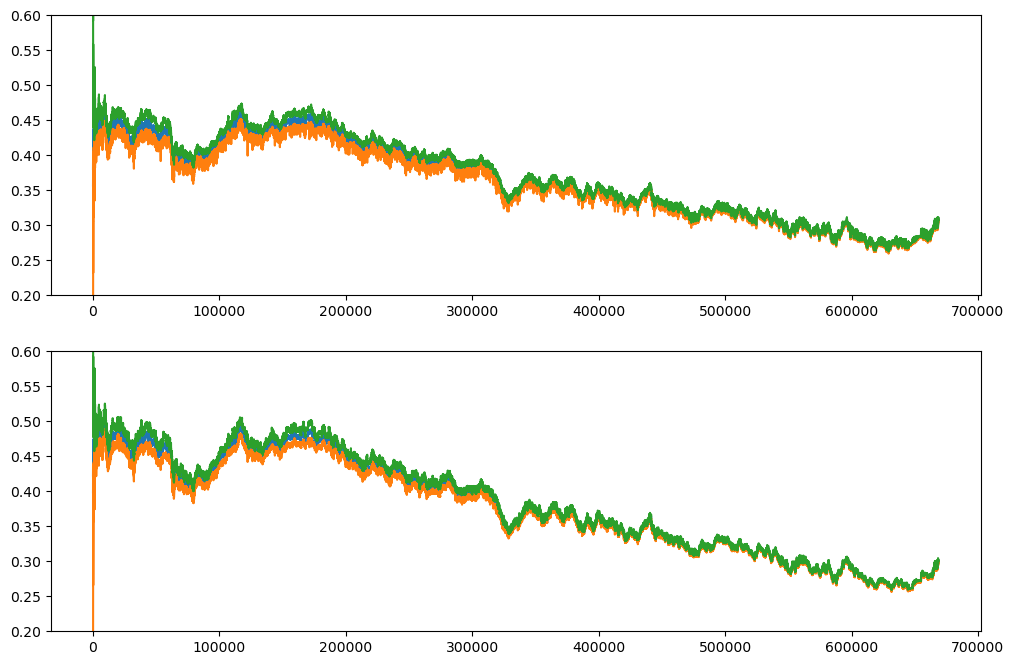

In [14]:
# Plot floors and ceilings against hidden valuations
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
ax[0].plot(df[['hidden_valuation_s', 's_floor_WBB', 's_ceil_WBB']])
ax[1].plot(df[['hidden_valuation_b', 'b_floor_WBB', 'b_ceil_WBB']])
ax[0].set_ylim(0.2, 0.6)
ax[1].set_ylim(0.2, 0.6)
plt.show()

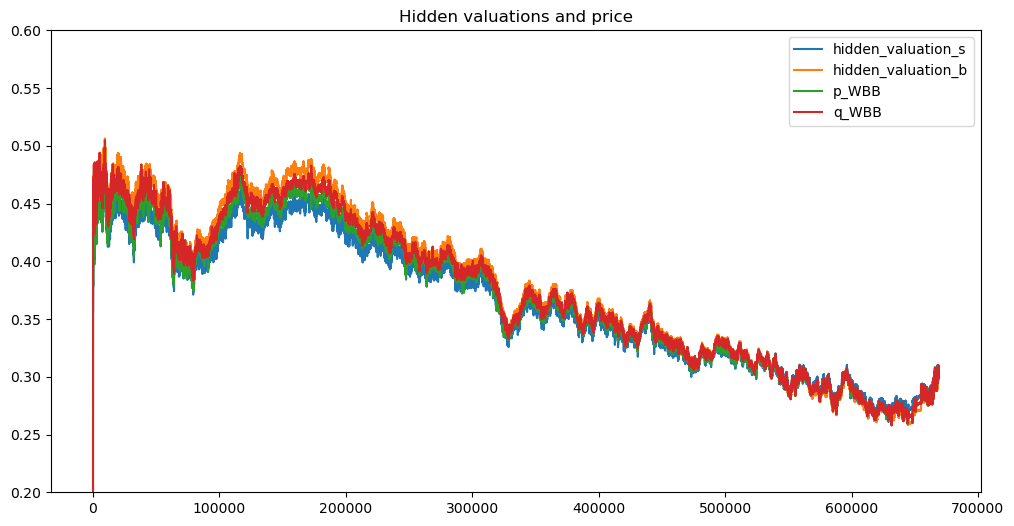

In [15]:
# Plot price against hidden valuations
df[['hidden_valuation_s', 'hidden_valuation_b', 'p_WBB', 'q_WBB']].plot(figsize=(12, 6))
plt.title('Hidden valuations and price')
plt.ylim(0.2, 0.6)
plt.show()

Percentage of accepted trades: 0.7533244114150711
Cumulative Gain From Trade: 8489.496583101567
Optimal Gain From Trade: 8558.153490124405
Cumulative Revenues: 2245.339154178519


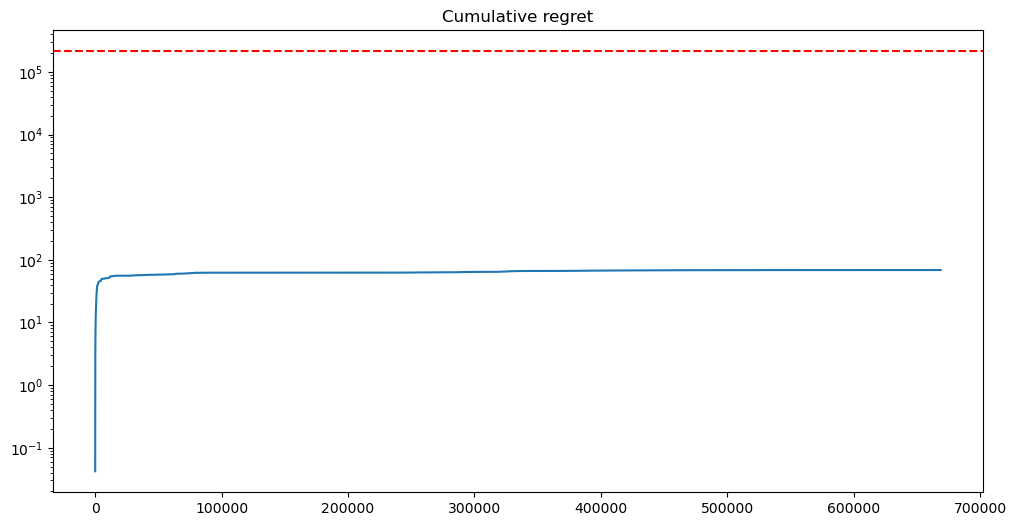

In [36]:
# Percentage of accepted trades (SBB)
accepted = (df['p_WBB'] >= df['hidden_valuation_s']) & (df['q_WBB'] <= df['hidden_valuation_b'])
gft = accepted * (df['hidden_valuation_b'] - df['hidden_valuation_s'])
optimal_gft = (df['hidden_valuation_b'] - df['hidden_valuation_s']).clip(0)
regret = optimal_gft - gft
revenues = accepted * (df['q_WBB'] - df['p_WBB'])
print(f"Percentage of accepted trades: {accepted.mean()}")
print(f"Cumulative Gain From Trade: {gft.sum()}")
print(f"Optimal Gain From Trade: {optimal_gft.sum()}")
print(f"Cumulative Revenues: {revenues.sum()}")

# Theoretical worst-case regret
theoretical_regret = 10 * DIMENSIONS ** 2 * np.log(20*(DIMENSIONS+1)*T/DIMENSIONS**2)

# Plot the cumulative regret
regret.cumsum().plot(figsize=(12, 6))
plt.axhline(theoretical_regret, color='red', linestyle='--')
plt.title('Cumulative regret')
plt.yscale('log')
plt.show()

We now cut the two ellipsoids at once, whenever possible. Very deep or very shallow cuts can lead to numerical instability, so we cut when the depth is within -0.5 and 0.5. 

In [37]:
df['s_floor_SBB_cuts'] = None
df['s_ceil_SBB_cuts'] = None
df['b_floor_SBB_cuts'] = None
df['b_ceil_SBB_cuts'] = None
df['p_SBB_cuts'] = None

T = df.shape[0]
EPSILON = 1*1*DIMENSIONS**2/T
brokerSBB = EllipsoidPricingSBBCuts(epsilon=EPSILON, d=DIMENSIONS)

for i in tqdm(range(T)):
    x = df.iloc[i, :DIMENSIONS].values
    s = df.iloc[i, 41] # hidden_valuation_s
    b = df.iloc[i, 42] # hidden_valuation_b
    p, q = brokerSBB.get_price(x)
    feedback_s = s <= p
    feedback_b = b >= q
    brokerSBB.update_ellipsoids_with_cuts(feedback_s, feedback_b, p=p, q=q)
    # The budget will always be 0

    # Save the valuation bounds and the price
    df.loc[i, 's_floor_SBB_cuts'] = brokerSBB.s_floor
    df.loc[i, 's_ceil_SBB_cuts'] = brokerSBB.s_ceil
    df.loc[i, 'b_floor_SBB_cuts'] = brokerSBB.b_floor
    df.loc[i, 'b_ceil_SBB_cuts'] = brokerSBB.b_ceil
    df.loc[i, 'p_SBB_cuts'] = p

100%|██████████| 668765/668765 [05:56<00:00, 1877.04it/s]


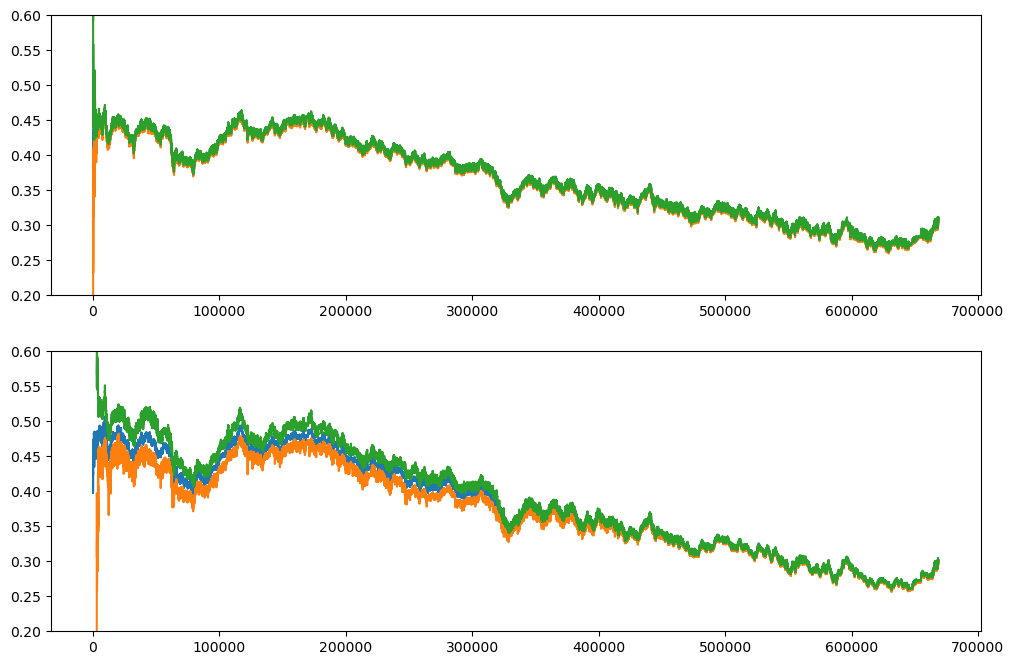

In [253]:
# Plot floors and ceilings against hidden valuations
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
ax[0].plot(df[['hidden_valuation_s', 's_floor_SBB_cuts', 's_ceil_SBB_cuts']])
ax[1].plot(df[['hidden_valuation_b', 'b_floor_SBB_cuts', 'b_ceil_SBB_cuts']])
ax[0].set_ylim(0.2, 0.6)
ax[1].set_ylim(0.2, 0.6)
plt.show()

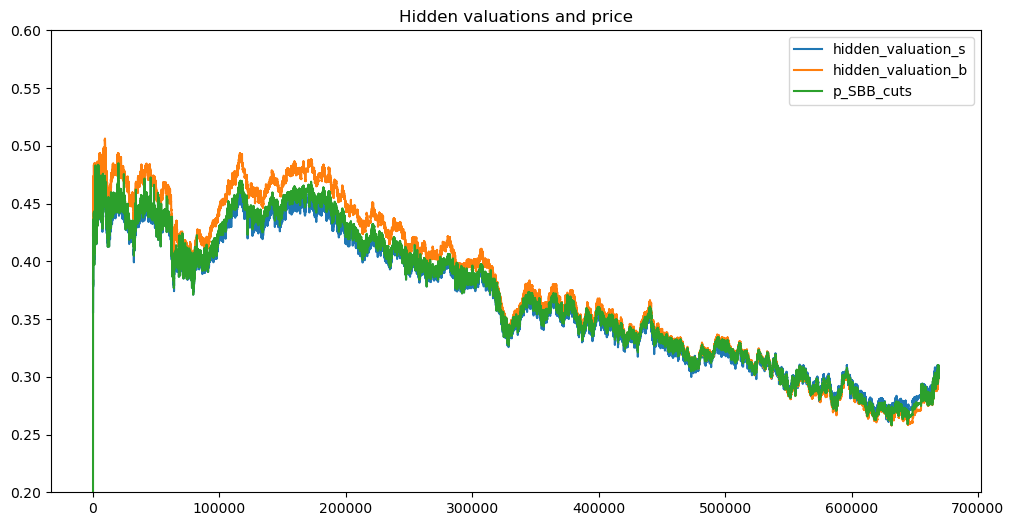

In [254]:
# Plot price against hidden valuations
df[['hidden_valuation_s', 'hidden_valuation_b', 'p_SBB_cuts']].plot(figsize=(12, 6))
plt.title('Hidden valuations and price')
plt.ylim(0.2, 0.6)
plt.show()

Percentage of accepted trades: 0.7512010945548885
Cumulative Gain From Trade: 8459.949981463782
Optimal Gain From Trade: 8558.153490124405


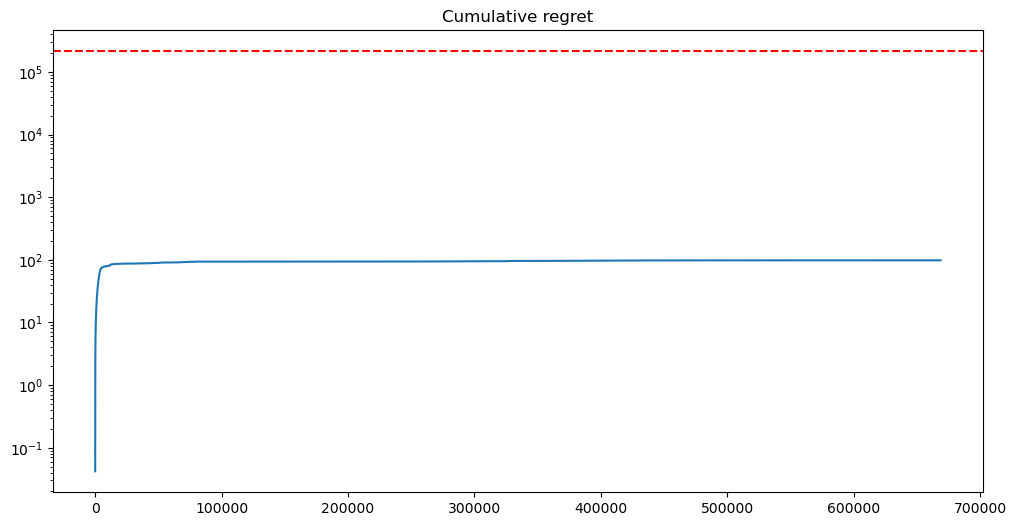

In [38]:
# Percentage of accepted trades
accepted = (df['p_SBB_cuts'] >= df['hidden_valuation_s']) & (df['p_SBB_cuts'] <= df['hidden_valuation_b'])
gft = accepted * (df['hidden_valuation_b'] - df['hidden_valuation_s'])
optimal_gft = (df['hidden_valuation_b'] - df['hidden_valuation_s']).clip(0)
regret = optimal_gft - gft
print(f"Percentage of accepted trades: {accepted.mean()}")
print(f"Cumulative Gain From Trade: {gft.sum()}")
print(f"Optimal Gain From Trade: {optimal_gft.sum()}")

# Theoretical worst-case regret
theoretical_regret = 10 * DIMENSIONS ** 2 * np.log(20*(DIMENSIONS+1)*T/DIMENSIONS**2)

# Plot the cumulative regret
regret.cumsum().plot(figsize=(12, 6))
plt.axhline(theoretical_regret, color='red', linestyle='--')
plt.title('Cumulative regret')
plt.yscale('log')
plt.show()

In [39]:
df['s_floor_WBB_cuts'] = None
df['s_ceil_WBB_cuts'] = None
df['b_floor_WBB_cuts'] = None
df['b_ceil_WBB_cuts'] = None
df['p_WBB_cuts'] = None

T = df.shape[0]
EPSILON = 1*1*DIMENSIONS**2/T
brokerWBB = EllipsoidPricingWBBCuts(epsilon=EPSILON, d=DIMENSIONS)

for i in tqdm(range(T)):
    x = df.iloc[i, :DIMENSIONS].values
    s = df.iloc[i, 41] # hidden_valuation_s
    b = df.iloc[i, 42] # hidden_valuation_b
    p, q = brokerWBB.get_price(x)
    feedback_s = s <= p
    feedback_b = b >= q
    brokerWBB.update_ellipsoids_with_cuts(feedback_s, feedback_b, p=p, q=q)
    # The budget will always be 0

    # Save the valuation bounds and the price
    df.loc[i, 's_floor_WBB_cuts'] = brokerWBB.s_floor
    df.loc[i, 's_ceil_WBB_cuts'] = brokerWBB.s_ceil
    df.loc[i, 'b_floor_WBB_cuts'] = brokerWBB.b_floor
    df.loc[i, 'b_ceil_WBB_cuts'] = brokerWBB.b_ceil
    df.loc[i, 'p_WBB_cuts'] = p
    df.loc[i, 'q_WBB_cuts'] = q

100%|██████████| 668765/668765 [06:15<00:00, 1778.69it/s]


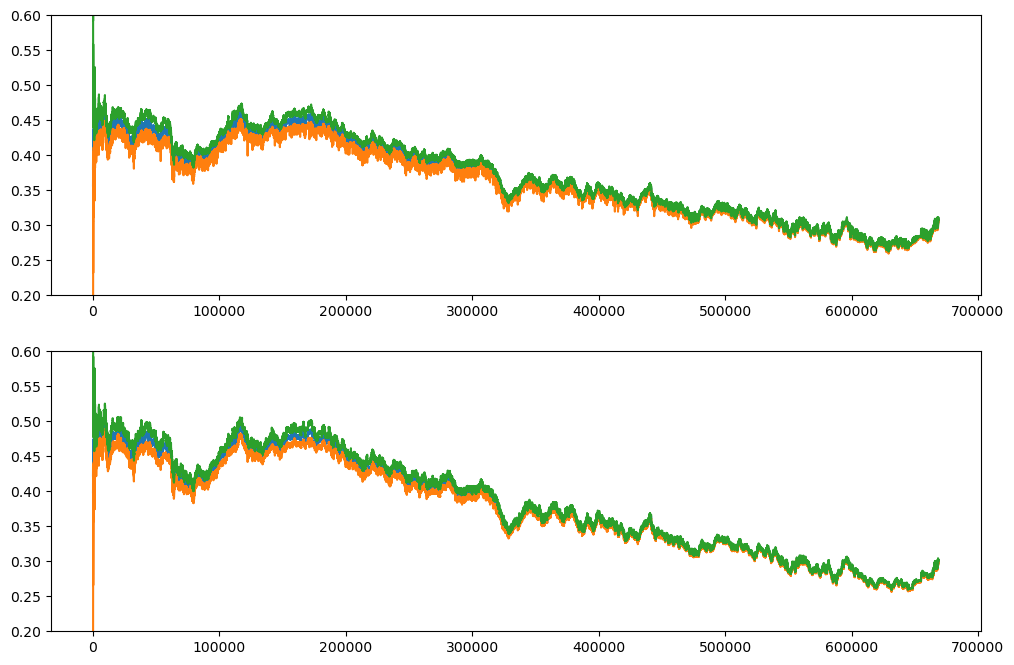

In [21]:
# Plot floors and ceilings against hidden valuations
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
ax[0].plot(df[['hidden_valuation_s', 's_floor_WBB_cuts', 's_ceil_WBB_cuts']])
ax[1].plot(df[['hidden_valuation_b', 'b_floor_WBB_cuts', 'b_ceil_WBB_cuts']])
ax[0].set_ylim(0.2, 0.6)
ax[1].set_ylim(0.2, 0.6)
plt.show()

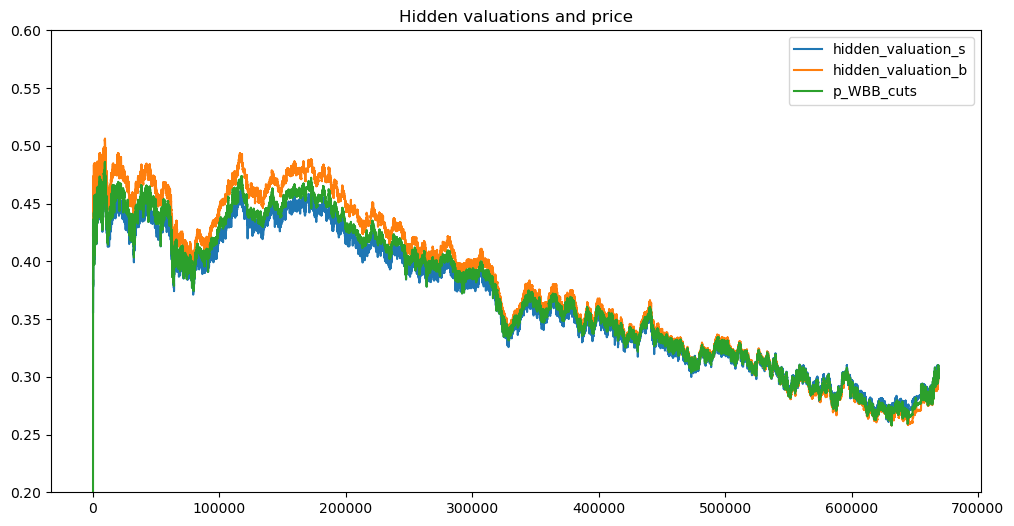

In [22]:
# Plot price against hidden valuations
df[['hidden_valuation_s', 'hidden_valuation_b', 'p_WBB_cuts']].plot(figsize=(12, 6))
plt.title('Hidden valuations and price')
plt.ylim(0.2, 0.6)
plt.show()

Percentage of accepted trades: 0.7543427063318205
Cumulative Gain From Trade: 8510.964594024488
Optimal Gain From Trade: 8558.153490124405
Cumulative Revenues: 2266.9149417954195


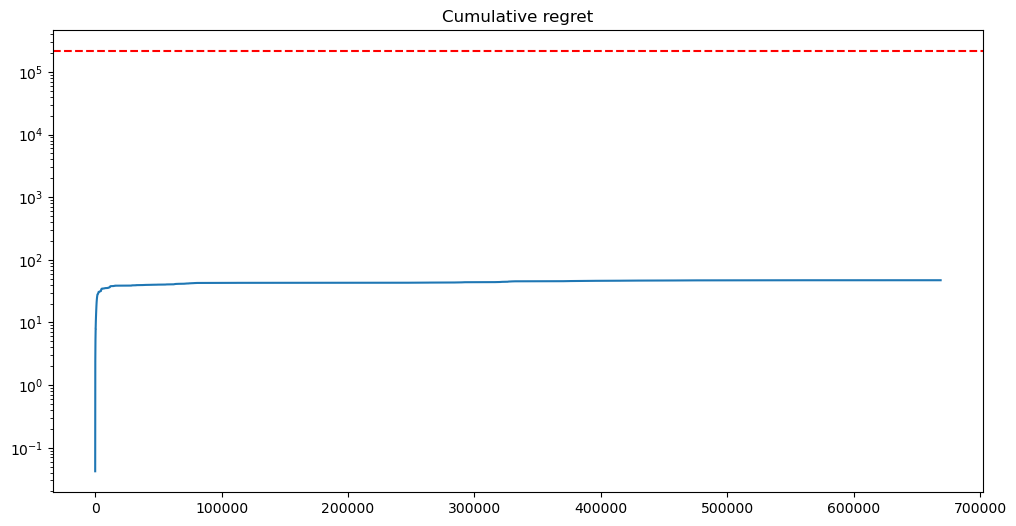

In [40]:
# Percentage of accepted trades
accepted = (df['p_WBB_cuts'] >= df['hidden_valuation_s']) & (df['p_WBB_cuts'] <= df['hidden_valuation_b'])
gft = accepted * (df['hidden_valuation_b'] - df['hidden_valuation_s'])
optimal_gft = (df['hidden_valuation_b'] - df['hidden_valuation_s']).clip(0)
regret = optimal_gft - gft
revenues = accepted * (df['q_WBB'] - df['p_WBB'])
print(f"Percentage of accepted trades: {accepted.mean()}")
print(f"Cumulative Gain From Trade: {gft.sum()}")
print(f"Optimal Gain From Trade: {optimal_gft.sum()}")
print(f"Cumulative Revenues: {revenues.sum()}")

# Theoretical worst-case regret
theoretical_regret = 10 * DIMENSIONS ** 2 * np.log(20*(DIMENSIONS+1)*T/DIMENSIONS**2)

# Plot the cumulative regret
regret.cumsum().plot(figsize=(12, 6))
plt.axhline(theoretical_regret, color='red', linestyle='--')
plt.title('Cumulative regret')
plt.yscale('log')
plt.show()

In [2]:
# Save the results
# df.to_csv('results_ellipsoid.csv', index=False)

# Load the results
df = pd.read_csv('results_ellipsoid.csv')

## Noisy hidden valuations

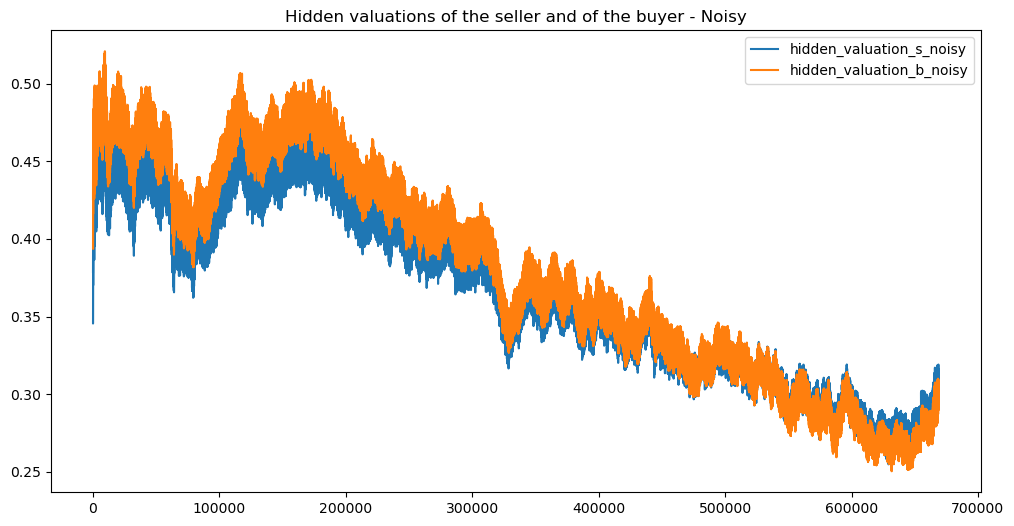

In [4]:
# Let's now add some noise to the hidden valuations
# Sample from a uniform distribution with between -3% and 3% of the hidden valuation
df['hidden_valuation_s_noisy'] = df['hidden_valuation_s'] * (1+np.random.uniform(-0.03, 0.03, size=df.shape[0]))
df['hidden_valuation_b_noisy'] = df['hidden_valuation_b'] * (1+np.random.uniform(-0.03, 0.03, size=df.shape[0]))

# Plot the hidden valuations on top of each other
df[['hidden_valuation_s_noisy', 'hidden_valuation_b_noisy']].plot(figsize=(12, 6))
plt.title('Hidden valuations of the seller and of the buyer - Noisy')
plt.show()

In [4]:
class ExploreOrCommit:
    """
    This algorithm has not been optimized yet. The code runs in 15 hours - too much. 

    Attributes:
    mu: float
    T_int: int, length of exploration phase for estimating the integrals I and J
    T_FD: int, length of exploration phase for estimating the function F and the demand function D
    epsilon: float, discretization error
    delta: float, confidence parameter
    d: int, dimension of the feature space
    A: float, bound on theta
    B: float, bound on the information vector
    C: float, bound on the noise
    P: float, bound on the price
    Tau_par: list, list of indices of the exploration phase for estimating the parameters
    Tau_int: list, list of indices of the exploration phase for estimating the integrals
    Tau_F: dict, dictionary of lists of indices of the exploration phase for estimating the function F, keys = k
    Tau_D: dict, dictionary of lists of indices of the exploration phase for estimating the demand function D, keys = k
    theta_s: np.array, estimates of seller's hidden valuation
    theta_b: np.array, estimates of buyer's hidden valuation
    V: np.array, covariance matrix, initialized as the identity matrix
    k: int, grid interval
    K: list, list of grid intervals
    F_k_estimates: dict, dictionary of estimates of F, keys = k
    D_k_estimates: dict, dictionary of estimates of D, keys = k
    I_estimates: dict, dictionary of estimates of I, keys = k
    J_estimates: dict, dictionary of estimates of J, keys = k
    update_par: bool, flag for updating the parameters
    update_int: bool, flag for updating the integrals
    update_F: bool, flag for updating the function F
    update_D: bool, flag for updating the demand function D
    update_F_k: int, index for updating the function F
    update_D_k: int, index for updating the demand function D
    """
    def __init__(self, mu:float, T_int:int, T_FD:int, epsilon:float, delta:float, d:int, A:float, B:float, C:float)->None:
        self.mu:float = mu
        assert mu > 0
        self.T_int:int = T_int
        self.T_FD:int = T_FD
        self.epsilon:float = epsilon
        self.delta:float = delta
        self.d:int = d
        self.A:float = A 
        self.B:float = B
        self.C:float = C
        self.P:float = C + A * B
        self.Tau_par:List[int] = []
        self.Tau_int:List[int] = []
        self.Tau_F:Dict[List[int]] = {}
        self.Tau_D:Dict[List[int]] = {}
        self.theta_s:np.array = np.zeros(d)
        self.theta_b:np.array = np.zeros(d) 
        self.V:np.array = np.eye(d) 
        self.k:int = int(1 + 2*self.P/self.epsilon) + 3 # the int(1+x) truncation is for taking the ceiling
        self.K:List[int] = list(range(-self.k, self.k+1))
        self.F_k_estimates:Dict[int] = {0 for k in self.K}
        self.D_k_estimates:Dict[int] = {0 for k in self.K}
        self.I_estimates:Dict[int] = {0 for k in self.K}
        self.J_estimates:Dict[int] = {0 for k in self.K}
        self.update_par:bool = False
        self.update_int:bool = False
        self.update_F:bool = False
        self.update_D:bool = False
        self.update_F_k:int = -self.k
        self.update_D_k:int = -self.k
        

    def get_price(self, x:np.array, i:int, X:pd.DataFrame) -> Tuple[float, float]:
        """
        This function calculates and returns the prices for the seller and the buyer.
        """

        if np.sqrt(x.T @ np.linalg.inv(self.V) @ x) > self.mu:
            # Draw a random price from -P to P
            p = np.random.uniform(-self.P, self.P)
            self.Tau_par.append(i)
            self.update_par = True
            X_array = X.iloc[self.Tau_par, :self.d]
            self.V = np.linalg.inv(X_array.T @ X_array + np.eye(self.d))

        elif len(self.Tau_int) < self.T_int:
            # Draw a random price from -P to P
            p = np.random.uniform(-self.P, self.P)

            self.Tau_int.append(i)
            if len(self.Tau_int) == self.T_int:
                self.update_int = True

        elif self.update_F_k <= self.k:
            p = x @ self.theta_s + self.update_F_k * self.epsilon
            self.Tau_F[self.update_F_k].append(i)
            if len(self.Tau_F[self.update_F_k]) == self.T_FD:
                self.update_F = True

        elif self.update_D_k <= self.k:
            p = x @ self.theta_b + self.update_D_k * self.epsilon
            self.Tau_D[self.update_D_k].append(i)
            if len(self.Tau_D[self.update_D_k]) == self.T_FD:
                self.update_D = True

        else:
            max_k = None
            max_value = -np.inf
            for k in self.K:
                k_prime = max(-self.k, min(self.k, int((x @ (self.theta_s - self.theta_b) + k * self.epsilon) / self.epsilon)))
                value = self.I_estimates[k_prime] * self.F_k_estimates[k] + self.J_estimates[k] * self.D_k_estimates[k_prime]
                if value > max_value:
                    max_value = value
                    max_k = k
                
            p = x @ self.theta_s + max_k * self.epsilon

        return p, p
    
    def update_parameters(self, X:pd.DataFrame, feedback_s:pd.Series, feedback_b:pd.Series, prices:pd.Series)->None:
        """
        This function updates the parameters of the model.
        """
        if self.update_par:
            self.theta_s = (2 * self.P * self.V) @ ((feedback_s.iloc[self.Tau_par] - 0.5).values.reshape(-1, 1) * X.iloc[self.Tau_par, :self.d].values).sum(axis=0).T
            self.theta_b = (2 * self.P * self.V) @ ((feedback_b.iloc[self.Tau_par] - 0.5).values.reshape(-1, 1) * X.iloc[self.Tau_par, :self.d].values).sum(axis=0).T
            self.update_par = False

        if self.update_int:
            for k in self.K:
                self.I_estimates[k] = 2 * self.P / self.T_int * feedback_b.iloc[self.Tau_int] *\
                    (prices.iloc[self.Tau_int] >= k * self.epsilon + X.iloc[self.Tau_int, :self.d] @ self.theta_b).sum()
                self.J_estimates[k] = 2 * self.P / self.T_int * feedback_s.iloc[self.Tau_int] *\
                    (prices.iloc[self.Tau_int] <= k * self.epsilon + X.iloc[self.Tau_int, :self.d] @ self.theta_s).sum()
                
            self.update_int = False

        if self.update_F:
            self.F_k_estimates[self.update_F_k] = 2 * self.P / self.T_FD * feedback_s.iloc[self.Tau_F[self.update_F_k]].sum()
            self.update_F_k += 1
            self.update_F = False

        if self.update_D:
            self.D_k_estimates[self.update_D_k] = 2 * self.P / self.T_FD * feedback_b.iloc[self.Tau_D[self.update_D_k]].sum()
            self.update_D_k += 1
            self.update_D = False
        

In [9]:
df['p_SBB_EOC'] = None
df['feedback_s_EOC'] = None
df['feedback_b_EOC'] = None

DIMENSIONS = 41
T = df.shape[0]
EPSILON = (np.log(T)/T)**(1/4)
A = 1
B = 1
C = 0.03
P = C + A * B
DELTA = 1/(T*(74+32*P/EPSILON))
MU = EPSILON / (P * np.sqrt(DIMENSIONS * np.log((1+B**2*T)/DELTA)) + A)
T_int = int(8*P**2*np.log(1/DELTA)/EPSILON**2)+1
T_FD = int(2*np.log(1/DELTA)/EPSILON**2)+1

brokerEOC = ExploreOrCommit(mu=MU, T_int=T_int, T_FD=T_FD, epsilon=EPSILON, delta=DELTA, d=DIMENSIONS, A=A, B=B, C=C)

print(f"MU: {MU}")
print(f"T_int: {T_int}")
print(f"T_FD: {T_FD}")
print(f"EPSILON: {EPSILON}")
print(f"DELTA: {DELTA}")

MU: 0.0017167351296721832
T_int: 37434
T_FD: 8822
EPSILON: 0.06692133853370558
DELTA: 2.6394432943284816e-09


In [ ]:
for i in tqdm(range(T)):
    x = df.iloc[i, :DIMENSIONS].values
    s = df.iloc[i, 41] # hidden_valuation_s
    b = df.iloc[i, 42] # hidden_valuation_b
    p, q = brokerEOC.get_price(x=x, i=i, X=df)
    feedback_s = s <= p
    feedback_b = b >= q
    df.loc[i, 'p_SBB_EOC'] = p # Save the price
    df.loc[i, 'feedback_s_EOC'] = feedback_s # Save the feedback of the seller
    df.loc[i, 'feedback_b_EOC'] = feedback_b # Save the feedback of the buyer

    brokerEOC.update_parameters(X=df, feedback_s=df['feedback_s_EOC'], feedback_b=df['feedback_b_EOC'], prices=df['p_SBB_EOC'])    